### Load .py file
%load 02_generate_population.py 

### Merge lines
Merge all selected lines with Shift + M

### Write 
%%writefile 02_generate_population.py

In [2]:
from sklearn.neighbors import NearestNeighbors
from rtree import index
from shapely.wkt import loads
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import contextily as ctx
import random
import time
import os

/Users/tjark/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_2826/3750943938.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://s

In [3]:
pwd

'/Users/tjark/Documents/Python/CairoPopulation.nosync/tfc-git/population'

In [4]:
#move working directory up to acces data with relative paths
os.chdir("..")

### Part 1: Scale up individuals based on household weight mean

In [5]:
#load individual LFS data of GCR from csv
ind = pd.read_csv('data/interim/ind.csv')

In [6]:
#load address points within GCR with ADM3_PCODE assigned shapefile 
gcraddr = gpd.read_file('data/interim/gcrpts.shp')

In [7]:
len(gcraddr)

1204766

In [6]:
#Count number of different ADM3 areas with LFS data
print("There are",ind.groupby('ADM3_PCODE').count().count()[1],
      "ADM3_PCODE areas with LFS dat11 Rue Joliot Curiea points of a total of",
      gcraddr.groupby('ADM3_PCODE').count().count()[1],"areas.")

There are 259 ADM3_PCODE areas with LFS dat11 Rue Joliot Curiea points of a total of 489 areas.


In [7]:
#calculate mean weight for each household, only keep column of weights
hhmean = ind.groupby('CASESER').mean().iloc[:,7]

/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_1761/3045037954.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hhmean = ind.groupby('CASESER').mean().iloc[:,7]


In [8]:
#merge dfs of LFS and mean weights
indwght = pd.merge(ind,hhmean,on='CASESER')

In [9]:
indwght.head()

,Unnamed: 0.1,Unnamed: 0,COUNTRY,YEAR,ROUND,DTYPE,CASESER,PNUM,PWEIGHT_x,REG,...,SRCHACT_05,SRCHACT_06,SRCHACT_07,SRCHACT_08,SRCHACT_09,SRCHACT_10,SRCHACT_90,NOTSRCH_R,ADM3_PCODE,PWEIGHT_y
0,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057
1,1,2,818,2018,1,1,10110110150001,2,403.016385,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202,340.944057
2,2,3,818,2018,1,1,10110110150001,3,403.016385,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202,340.944057
3,3,4,818,2018,1,1,10110110150001,4,270.249019,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202,340.944057
4,4,5,818,2018,1,1,10110110150002,1,367.696135,818001,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,EG013202,354.097778


In [10]:
# define a function to scale up the rows and add new IDs to each nth occurrence
def scale_rows(df_group):
    # calculate the number of times to repeat each row
    weight = df_group['PWEIGHT_y'].iloc[0]
    # repeat each row based on the weight column
    df_group = df_group.iloc[np.repeat(np.arange(len(df_group)), weight)]
    # add new IDs for each new occurrence, restarting for each initial ID
    df_group['HHID'] = np.arange(len(df_group)) % weight
    return df_group

# apply the scaling function to each group of rows with the same ID
ind_scaled = indwght.groupby('Unnamed: 0.1').apply(scale_rows)

# reset the index of the new dataframe
ind_scaled.reset_index(drop=True, inplace=True)

In [11]:
ind_reindex = ind_scaled

In [12]:
ind_reindex['HHID'] = ind_reindex['HHID'].astype(int).astype(str)

In [13]:
ind_reindex.head()

,Unnamed: 0.1,Unnamed: 0,COUNTRY,YEAR,ROUND,DTYPE,CASESER,PNUM,PWEIGHT_x,REG,...,SRCHACT_06,SRCHACT_07,SRCHACT_08,SRCHACT_09,SRCHACT_10,SRCHACT_90,NOTSRCH_R,ADM3_PCODE,PWEIGHT_y,HHID
0,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057,0
1,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057,1
2,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057,2
3,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057,3
4,0,1,818,2018,1,1,10110110150001,1,287.494438,818001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,340.944057,4


In [14]:
# Add zeros before ID to always have four digits
def replace_value(x):
    if len(x) == 1:
        return '000'+x
    elif len(x) == 2:
        return '00'+x
    elif len(x) == 3:
        return '0'+x
    else: 
        return x

# use apply method to apply the custom function to each element in the 'col' column
ind_reindex['HHID'] = ind_reindex['HHID'].apply(replace_value)

In [15]:
#Create new HHID based on CESASER and new ID from scaling
ind_reindex['HHID'] = ind_reindex['CASESER'].astype(str) + ind_reindex['HHID']

In [16]:
#Delete all columns not needed
#command to show columns as list: ind_reindex.columns.values.tolist()
ind_reindex = ind_reindex.drop(columns=['Unnamed: 0.1','Unnamed: 0','COUNTRY','YEAR','ROUND',
                                     'PWEIGHT_x','PWEIGHT_y'])

In [17]:
print(len(ind_reindex))
ind_reindex.head()

20672421


,DTYPE,CASESER,PNUM,REG,AREA,AREA_S,RURURB,AGE,SEX,MART,...,SRCHACT_05,SRCHACT_06,SRCHACT_07,SRCHACT_08,SRCHACT_09,SRCHACT_10,SRCHACT_90,NOTSRCH_R,ADM3_PCODE,HHID
0,1,10110110150001,1,818001,8180132,818013202,1,49,2,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,101101101500010000
1,1,10110110150001,1,818001,8180132,818013202,1,49,2,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,101101101500010001
2,1,10110110150001,1,818001,8180132,818013202,1,49,2,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,101101101500010002
3,1,10110110150001,1,818001,8180132,818013202,1,49,2,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,101101101500010003
4,1,10110110150001,1,818001,8180132,818013202,1,49,2,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202,101101101500010004


In [24]:
hhids = ind_reindex[['AGE','SEX','ATTSCH','ADM3_PCODE','HHID']]

### Part 2: Assign random locations to each household

In [25]:
areas = gpd.read_file('data/raw/eg_admin_boundaries/tfc_adm2_bounds_gcr.geojson')
areas['pop_total'] = round(20672421 * areas['pop_percent'])
areas.head(3)

,gid,gov_name,sec_name_a,name,density,area_hect,population,pop_percent,geometry,pop_total
0,2,القاهره,قسم حلوان,Qesm Helwan,7383,56,413448,0.030,"MULTIPOLYGON (((31.34027 29.87526, 31.34032 29...",620173.0
1,246,الجيزه,مركز البدرشين,Markaz El Badrashin,2961,135,399735,0.029,"MULTIPOLYGON (((31.21578 29.91131, 31.21585 29...",599500.0
2,3,القاهره,قسم المعصره,Qesm El Masara,11787,14,165018,0.012,"MULTIPOLYGON (((31.28030 29.91904, 31.28033 29...",248069.0


In [26]:
# Read the adm3 shapefile and reproject to EPSG:4326
adm3 = gpd.read_file('data/raw/eg_admin_boundaries/egy_admbnda_adm3_capmas_20170421.shp').to_crs("EPSG:4326")
# Create a new GeoDataFrame adm3_centroids with the centroids of the reprojected geometries
adm3_centroids = gpd.GeoDataFrame(geometry=adm3.centroid)
# Merge the attributes from adm3 back to adm3_centroids using the index
adm3_centroids = adm3_centroids.merge(adm3, left_index=True, right_index=True)
# Convert back to GeoDataFrame
adm3_centroids = gpd.GeoDataFrame(adm3_centroids, geometry='geometry_x',crs=adm3.crs)

/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_1761/2487757249.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  adm3_centroids = gpd.GeoDataFrame(geometry=adm3.centroid)


In [27]:
adm3_centroids = adm3_centroids[adm3_centroids['ADM3_PCODE'].isin(hhids['ADM3_PCODE'].unique())]

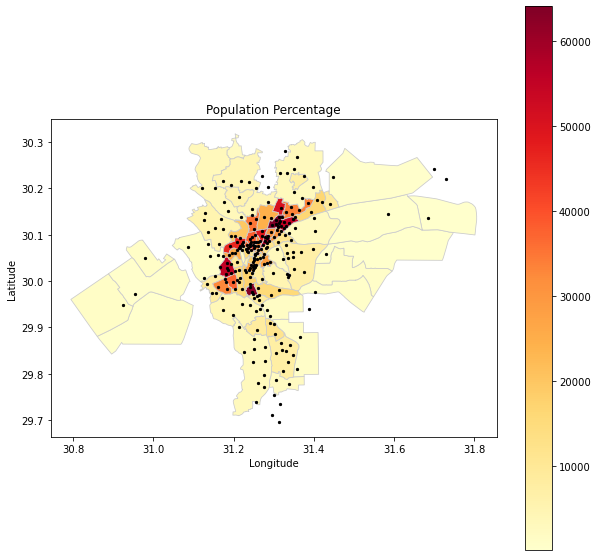

In [28]:
# Plot the GeoDataFrame with graduated colors
fig, ax = plt.subplots(figsize=(10, 10))
areas.plot(column='density', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Plot the points from adm3_centroids on the same plot
adm3_centroids.plot(ax=ax, color='black', markersize=5)

# Set plot title and axis labels
plt.title('Population Percentage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [29]:
# Number of nearest neighbors to find
k = 5

# Create a Nearest Neighbors model
nn = NearestNeighbors(n_neighbors=k)

# Fit the model with the coordinates of adm3_centroids
nn.fit(adm3_centroids.geometry.apply(lambda x: (x.x, x.y)).tolist())

# Find the k nearest neighbors for each polygon in areas
nearest_indices = nn.kneighbors(areas.geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).tolist(), return_distance=False)

# Retrieve the ADM3_PCODE values for the nearest points
nearest_pcodes = [adm3_centroids.iloc[indices]['ADM3_PCODE'].tolist() for indices in nearest_indices]

# Add the ADM3_PCODE values as a new column in areas
areas['Nearest_PCODE'] = nearest_pcodes

## Prep addresses with gid from ADM2 layer

In [30]:
# load addresses 
gcr_addresses = gpd.read_file('data/interim/gcr_addresses.shp')
gcr_addresses = gcr_addresses.to_crs('EPSG:4326')
gcr_addresses = gcr_addresses['geometry']
gcr_addresses = gpd.GeoDataFrame(geometry=gcr_addresses)

In [31]:
# print key info 
print(gcr_addresses.info())
print(gcr_addresses.crs)
print('______________')
print(gcr_addresses.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1845588 entries, 0 to 1845587
Data columns (total 1 columns):
 #   Column    Dtype   
---  ------    -----   
 0   geometry  geometry
dtypes: geometry(1)
memory usage: 14.1 MB
None
EPSG:4326
______________
                    geometry
0  POINT (31.21181 29.98708)
1  POINT (31.32804 30.09647)
2  POINT (31.38019 30.07878)
3  POINT (31.12789 29.98676)
4  POINT (31.23849 30.04761)


In [32]:
# prep data for areas
areas_temp = areas[['gid','geometry']]
# Perform the spatial join
joined_data = gpd.sjoin(gcr_addresses, areas_temp, how='left', predicate='intersects')
# Extract the 'gid' values from the joined polygons
joined_gid = joined_data['gid']
# Add the 'gid' values to the points dataset
gcr_addresses['gid'] = joined_gid
# print head
gcr_addresses.head(3)

,geometry,gid
0,POINT (31.21181 29.98708),239.0
1,POINT (31.32804 30.09647),39.0
2,POINT (31.38019 30.07878),40.0


## 1) Create one row for each individual per area
## 2) choose HHIDs 
HHIDs had to be scaled to make sure that sampling is representative. Each time, from five closest ADM3 areas is chosen due to data gaps

In [33]:
hhids.head(3)

,AGE,SEX,ATTSCH,ADM3_PCODE,HHID
0,49,2,0.0,EG013202,101101101500010000
1,49,2,0.0,EG013202,101101101500010001
2,49,2,0.0,EG013202,101101101500010002


#### Scale the areas database times the number of inhabitants per area

In [34]:
df = areas[['gid','Nearest_PCODE','pop_total']]
scaled_df = df.loc[df.index.repeat(df['pop_total'])].reset_index(drop=True)
scaled_df = scaled_df[['gid','Nearest_PCODE']]
scaled_df.head()

,gid,Nearest_PCODE
0,2,"[EG010201, EG010207, EG010208, EG010205, EG010..."
1,2,"[EG010201, EG010207, EG010208, EG010205, EG010..."
2,2,"[EG010201, EG010207, EG010208, EG010205, EG010..."
3,2,"[EG010201, EG010207, EG010208, EG010205, EG010..."
4,2,"[EG010201, EG010207, EG010208, EG010205, EG010..."


#### Attach one HHID from one of five closest ADM3_PCODE values to each row

In [35]:
df = scaled_df.copy()

# Create a dictionary mapping 'ADM3_PCODE' to a list of corresponding 'HHID' values
hhid_dict = hhids.groupby('ADM3_PCODE')['HHID'].apply(list).to_dict()

# Lambda function
df['HHID'] = df['Nearest_PCODE'].apply(lambda x: random.choice(hhid_dict.get(x[0], [])) if isinstance(x, list) else None)

In [36]:
df.head()

,gid,Nearest_PCODE,HHID
0,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300160076
1,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",208301163400100223
2,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300030163
3,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",202101163400140127
4,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300050244


In [37]:
print(len(df))
print(df.info())
print('–––––––––––––––––')
print(df.head(3))

20651746
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20651746 entries, 0 to 20651745
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   gid            int64 
 1   Nearest_PCODE  object
 2   HHID           object
dtypes: int64(1), object(2)
memory usage: 472.7+ MB
None
–––––––––––––––––
   gid                                      Nearest_PCODE                HHID
0    2  [EG010201, EG010207, EG010208, EG010205, EG010...  108301163300160076
1    2  [EG010201, EG010207, EG010208, EG010205, EG010...  208301163400100223
2    2  [EG010201, EG010207, EG010208, EG010205, EG010...  108301163300030163


#### Attach household data

In [60]:
HH_values = ind_reindex[['HHID','AGE','SEX','ATTSCH']]

In [53]:
df = df.reset_index()

In [54]:
len(df)

20651746

In [63]:
HHs = pd.merge(df, HH_values, on='HHID', how='left')

In [64]:
HHs

,index,gid,Nearest_PCODE,HHID,AGE,SEX,ATTSCH
0,0,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300160076,50,1,0.0
1,0,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300160076,50,2,0.0
2,0,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300160076,19,1,1.0
3,0,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",108301163300160076,83,2,0.0
4,1,2,"[EG010201, EG010207, EG010208, EG010205, EG010...",208301163400100223,38,1,0.0
...,...,...,...,...,...,...,...
96129502,20651744,14,"[EG011412, EG010806, EG010910, EG011517, EG010...",207301134800140086,35,1,0.0
96129503,20651745,14,"[EG011412, EG010806, EG010910, EG011517, EG010...",207301134800130330,48,2,0.0
96129504,20651745,14,"[EG011412, EG010806, EG010910, EG011517, EG010...",207301134800130330,24,1,0.0
96129505,20651745,14,"[EG011412, EG010806, EG010910, EG011517, EG010...",207301134800130330,21,1,1.0


In [66]:
# attempt to faster way than the one below
HHs = HHs.groupby('index').sample(n=1).reset_index(drop=True)

In [69]:
HHs = HHs[['gid','HHID','AGE','SEX','ATTSCH']]
HHs.head(3)

,gid,HHID,AGE,SEX,ATTSCH
0,2,108301163300160076,83,2,0.0
1,2,208301163400100223,32,2,0.0
2,2,108301163300030163,34,2,0.0


In [68]:
len(HHs)

20651746

In [450]:
# Replace NAs of ATTSCH with same distribution (62% not in school) with 1 and 0s

In [70]:
HHs['ATTSCH'] = HHs['ATTSCH'].fillna(pd.Series(np.random.choice([0, 1], size=len(HHs), p=[0.62, 1-0.62])))

#### Attach addresses

In [71]:
# delete NAs from gid 
gcr_addresses.dropna(subset=['gid'], inplace=True)

In [72]:
# convert gid to integrers for comparison
gcr_addresses['gid'] = gcr_addresses['gid'].astype(int)

In [73]:
gcr_addresses.head(3)

,geometry,gid
0,POINT (31.21181 29.98708),239
1,POINT (31.32804 30.09647),39
2,POINT (31.38019 30.07878),40


In [74]:
# Create a dictionary mapping gid values to lists of random geometries
geometry_dict = gcr_addresses.groupby('gid')['geometry'].apply(list).to_dict()

In [501]:
# HHs_test = HHs.head(250)

In [77]:
HHs['geometry'] = HHs['gid'].apply(lambda x: random.choice(geometry_dict.get(x, []))
                                        if isinstance(x, int) else None
                                        if (i + 1) % 100000 == 0 else None)


In [79]:
HHs.head(3)

,gid,HHID,AGE,SEX,ATTSCH,geometry
0,2,108301163300160076,83,2,0.0,POINT (31.33143 29.84543)
1,2,208301163400100223,32,2,0.0,POINT (31.31387 29.81446)
2,2,108301163300030163,34,2,0.0,POINT (31.30752 29.86069)


In [78]:
HHs_loc = gpd.GeoDataFrame(HHs, geometry='geometry')

In [80]:
HHs_loc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20651746 entries, 0 to 20651745
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   gid       int64   
 1   HHID      object  
 2   AGE       int64   
 3   SEX       int64   
 4   ATTSCH    float64 
 5   geometry  geometry
dtypes: float64(1), geometry(1), int64(3), object(1)
memory usage: 945.4+ MB


In [82]:
HHs_loc.to_csv('data/interim/scaled_pop_loc.csv')